# 34 Stationarity Experiment


## Fit ARiMA with Grouped Data

We require practical solutions to efficiently address stationarity in our time series modeling. One method where we might be able to more efficiently handle stationarity is by grouping individual article ids, resulting in a more manageable number of time series dataframes for which to set and check stationarity. The purpose of this notebook is to develop the coding pipeline necessary to fit an ARiMA model on grouped article unit sales and use proportioning to calculate predicted demand for individual article units.

## Setup

In [103]:
# general python and plotting packages
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [104]:
# ML packages
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import ADFTest
import pmdarima as pm
from sklearn.metrics import r2_score
from sklearn import linear_model

In [105]:
# display settings
pd.options.display.max_columns = 100

In [106]:
# code chunk to load data
# go to directory
%cd /data/p_dsi/teams2023/team7

# get sales data
temp = pd.read_csv("final_sales.csv", parse_dates=["DATE"])
print("Loading complete: final_sales.csv")

tire_sales = temp.drop(["Unnamed: 0"], axis=1)
print("Unnamed column dropped")

%cd /data/p_dsi/teams2023/bridgestone_data/data
# get store data
stores = pd.read_csv("store.csv", sep="|", usecols=["STORE_ID", "STATE_CODE", "ZIP_CODE"])
print("Loading complete: store.csv")

# get product data
products = pd.read_csv("product.csv", sep="|")
print("Loading complete: products.csv")
    
# join sales and store data, sort by date
temp = tire_sales.merge(stores, on="STORE_ID")
temp_products = temp.merge(products, on="ARTICLE_ID").set_index(["DATE"])
final_sales = temp_products.sort_values(by="DATE")

print('Parsing complete: tire_sales ready for testing')
print("Info on tire_sales: ", final_sales.info())

/gpfs52/data/p_dsi/teams2023/team7
Loading complete: final_sales.csv
Unnamed column dropped
/gpfs52/data/p_dsi/teams2023/bridgestone_data/data
Loading complete: store.csv
Loading complete: products.csv
Parsing complete: tire_sales ready for testing
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12354456 entries, 2015-04-01 to 2018-10-31
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   STORE_ID         int64  
 1   TRAN_ID          int64  
 2   ARTICLE_ID       int64  
 3   INDIV_ID         float64
 4   VEHICLE_ID       int64  
 5   UNITS            float64
 6   SALES            float64
 7   STATE_CODE       object 
 8   ZIP_CODE         int64  
 9   PROD_GROUP_CODE  float64
 10  PROD_GROUP_DESC  object 
 11  CATEGORY_CODE    float64
 12  CATEGORY_DESC    object 
 13  SEGMENT_CODE     float64
 14  SEGMENT_DESC     object 
 15  CLASS_CODE       float64
 16  CLASS_DESC       object 
 17  DISCOUNT_FLAG    object 
 18  CROSS_SECTION    

In [10]:
final_sales.head(3)

,STORE_ID,TRAN_ID,ARTICLE_ID,INDIV_ID,VEHICLE_ID,UNITS,SALES,STATE_CODE,ZIP_CODE,PROD_GROUP_CODE,PROD_GROUP_DESC,CATEGORY_CODE,CATEGORY_DESC,SEGMENT_CODE,SEGMENT_DESC,CLASS_CODE,CLASS_DESC,DISCOUNT_FLAG,CROSS_SECTION,ASPECT_RATIO,RIM_SIZE
DATE,,,,,,,,,,,,,,,,,,,,,
2015-04-01,244223,991392980,53967,277914583.0,907049261,2.0,303.98,MN,55902,5.0,Tires,26.0,Passenger Tires,30.0,P Metric Light Truck Tires,41.0,Highway Tires,N,275,55,20
2015-04-01,8028,991835500,123888,268710112.0,932136186,1.0,0.00,NY,14219,5.0,Tires,26.0,Passenger Tires,27.0,Touring,35.0,Economy Tires,N,215,60,16
2015-04-01,121916,990678420,95957,303348500.0,770798247,4.0,255.96,FL,32601,5.0,Tires,26.0,Passenger Tires,27.0,Touring,35.0,Economy Tires,N,225,70,15


### Custom functions

In [107]:
def split_and_store_data(df_dict, feature, freq_code): 
    '''
    Splits a sales dataframe on a given feature and returns as a dictionary of dataframes. 
    The keys are the unique values of the given feature, and the values are dataframes from final_sales filtered by that feature value.
    
    data = dataframe of tire sales 
    feature = (str) column name in the data dataframe
    freq_code = (str) one of: "D" = day; "W" = week; "M" = month
    
    '''
    feature_vals = df_dict[f"{feature}"].unique()
    
    feature_split_dict = {}
    
    for val in feature_vals:
        temp = df_dict.loc[df_dict[f"{feature}"] == val]
        temp_grouped = temp["UNITS"].groupby("DATE").sum()
        
        if freq_code != "D":
            temp_final = temp_grouped.resample(f"{freq_code}").sum().to_frame()
            feature_split_dict.update({f"{val}": temp_final})

        else:
            temp_final = temp_grouped.to_frame()
            feature_split_dict.update({f"{val}": temp_final})

    return feature_split_dict


def plot_ts_from_dict(df_dict):
    '''
    df_dict = dict returned from split_and_store_data()
    '''
    # get unique values of feature to loop over
    dict_keys = df_dict.keys() # e.g., feature = "STATE_CODE"
    
    # loop to get a plot for each df stored in the dict
    for k in dict_keys: 
        plt.figure(figsize=(15,10))
        df_dict.get(f"{k}").plot(title=(f"Total Unit Sales ({k})"))
        plt.show()
        
def train_test_split_from_dict(df_dict, train_period, test_period):
    '''
    train_period, test_period = string in datetime format
    '''
    
    train_test_split_dict = {}
    
    for k in df_dict.keys():
        temp_train = df_dict[k].loc[:train_period]
        temp_test = df_dict[k].loc[test_period]
        train_test_split_dict.update({k: [temp_train,temp_test]})
        
    return train_test_split_dict

def adf_results_from_dict(df_dict):
    # init empty dataframe to store results in 
    # index vals are the dictionary keys
    adfuller_results = pd.DataFrame(index=df_dict.keys(), 
                                    columns=["test_stat", "p_val"])
    
    # loop through dict keys and apply ADF test to training data
    # store in the adfuller_results dataframe
    for k in df_dict.keys():
        results = adfuller(df_dict[k][0])
        new_data = {"test_stat": results[0], "p_val": results[1]}
        new_df = pd.DataFrame(new_data, index=[k])
        adfuller_results.update(new_df)

    return adfuller_results

def transform_dfs_from_dict(df_dict, method, d=0):
    new_dict = {}
    
    # Apply transform method
    if method == "diff":
        for k in df_dict.keys():
            df_diff = df_dict[k][0].diff(d)
            df_diff = df_diff.dropna()
            new_dict.update({k: df_diff})

    elif method == "log":
        for k in df_dict.keys():
            df_log = np.log(df_dict[k][0] / df_dict[k][0].shift(1))
            df_log = df_log.dropna()
            new_dict.update({k: df_log})
    
    elif method == "sqrt":
        for k in df_dict.keys():
            df_sqrt = np.sqrt(df_dict[k][0])
            new_dict.update({k: df_sqrt})
    
    # ADF Test
    results_table = pd.DataFrame(index=df_dict.keys(), 
                                    columns=["test_stat", "p_val"])
   
    for k in new_dict.keys():
        results = adfuller(new_dict[k])
        new_data = {"test_stat": results[0], "p_val": results[1]}
        new_df = pd.DataFrame(new_data, index=[k])
        results_table.update(new_df)
            
    return new_dict, results_table

In [108]:
data_dict = split_and_store_data(df_dict=final_sales, feature="SEGMENT_DESC", freq_code="M")
data_dict.keys()

dict_keys(['P Metric Light Truck Tires', 'Touring', 'Performance Tires', 'Other Passenger Tires', 'Recreational Tires', 'P-Metric CUV/SUV', 'Commercial Tires'])

<Figure size 1080x720 with 0 Axes>

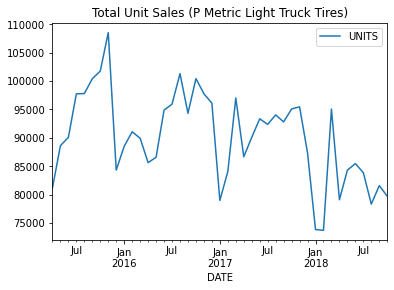

<Figure size 1080x720 with 0 Axes>

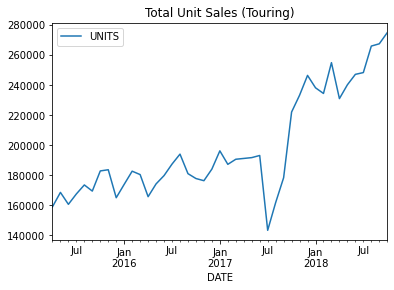

<Figure size 1080x720 with 0 Axes>

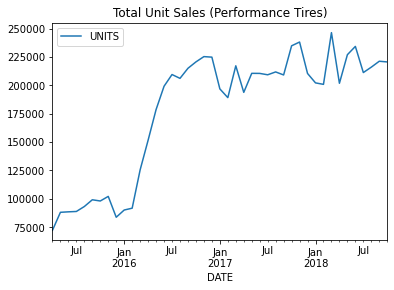

<Figure size 1080x720 with 0 Axes>

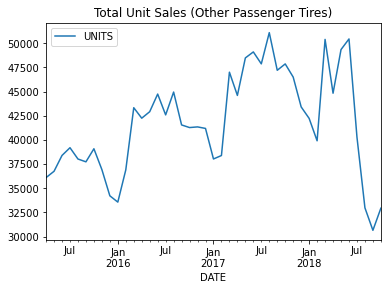

<Figure size 1080x720 with 0 Axes>

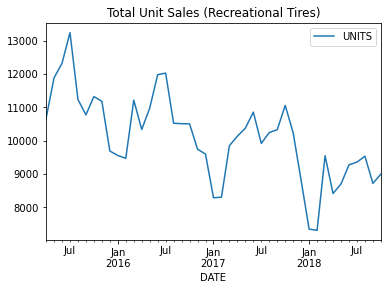

<Figure size 1080x720 with 0 Axes>

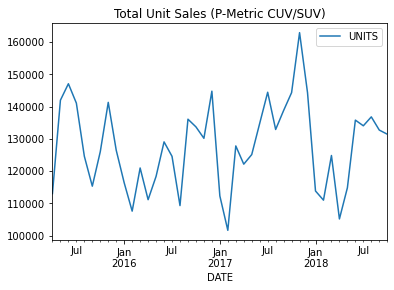

<Figure size 1080x720 with 0 Axes>

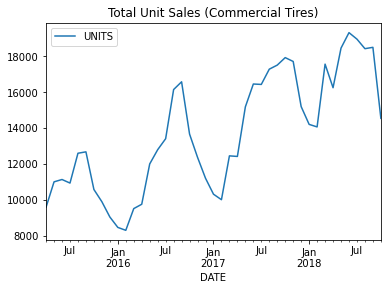

In [18]:
plot_ts_from_dict(data_dict)

In [21]:
data_dict_split = train_test_split_from_dict(df_dict=data_dict, train_period="2017", test_period="2018")

In [31]:
data_dict_diff_1 = transform_dfs_from_dict(data_dict_split, "diff", d=1)[0]
data_dict_log = transform_dfs_from_dict(data_dict_split, "log")[0]
data_dict_sqrt = transform_dfs_from_dict(data_dict_split, "sqrt")[0]
data_dict_diff_2 = transform_dfs_from_dict(data_dict_split, "diff", d=2)[0]

<Figure size 1080x720 with 0 Axes>

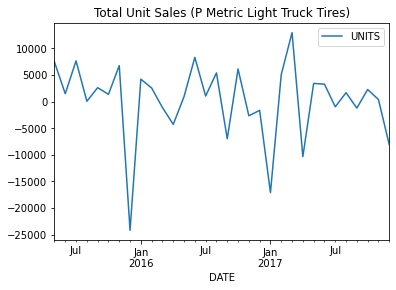

<Figure size 1080x720 with 0 Axes>

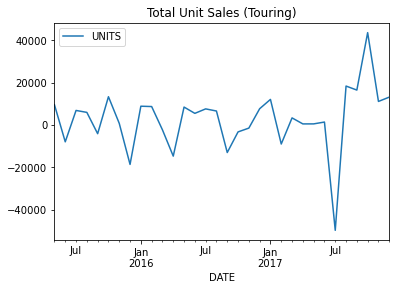

<Figure size 1080x720 with 0 Axes>

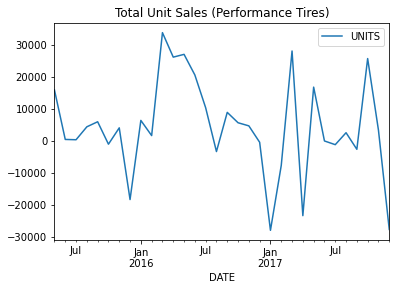

<Figure size 1080x720 with 0 Axes>

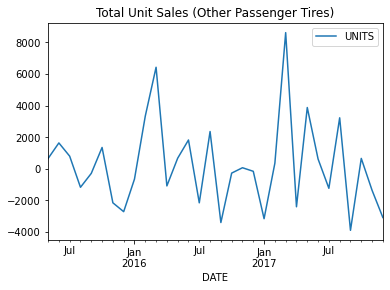

<Figure size 1080x720 with 0 Axes>

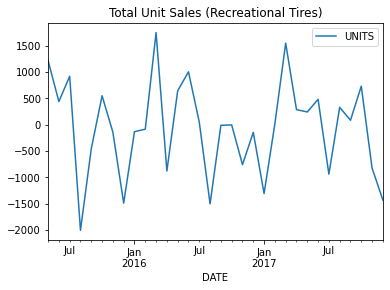

<Figure size 1080x720 with 0 Axes>

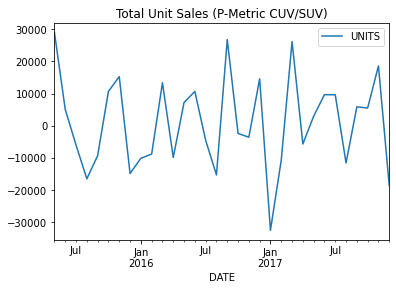

<Figure size 1080x720 with 0 Axes>

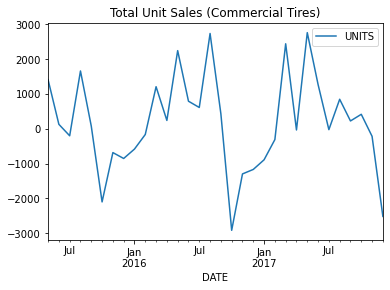

In [32]:
plot_ts_from_dict(data_dict_diff_1)

<Figure size 1080x720 with 0 Axes>

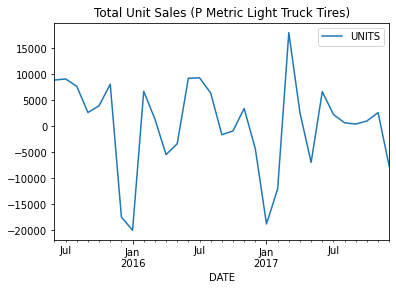

<Figure size 1080x720 with 0 Axes>

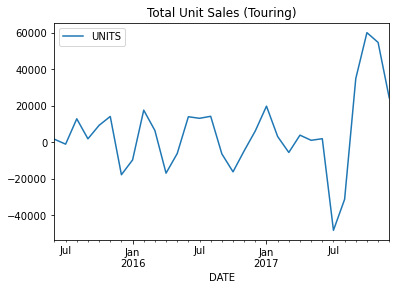

<Figure size 1080x720 with 0 Axes>

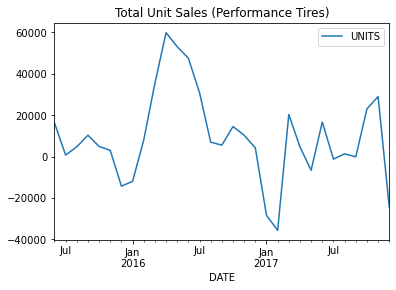

<Figure size 1080x720 with 0 Axes>

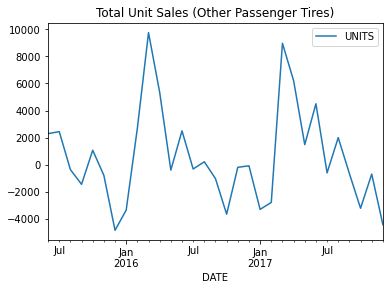

<Figure size 1080x720 with 0 Axes>

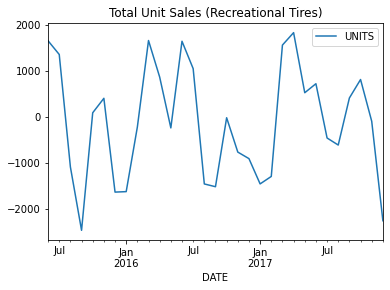

<Figure size 1080x720 with 0 Axes>

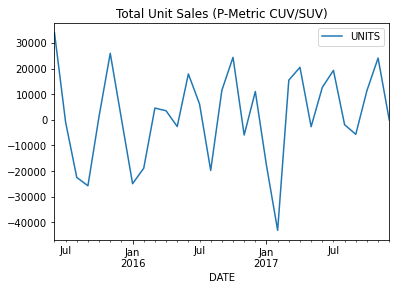

<Figure size 1080x720 with 0 Axes>

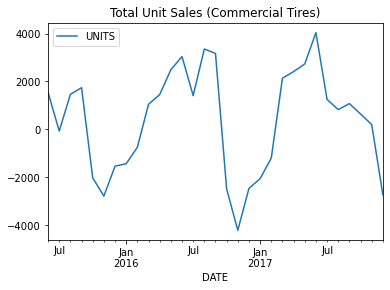

In [35]:
plot_ts_from_dict(data_dict_diff_2)

<Figure size 1080x720 with 0 Axes>

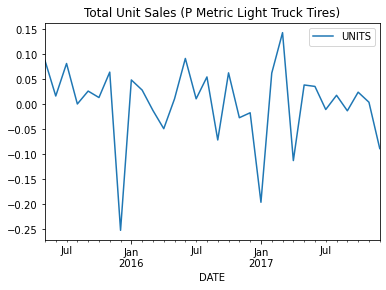

<Figure size 1080x720 with 0 Axes>

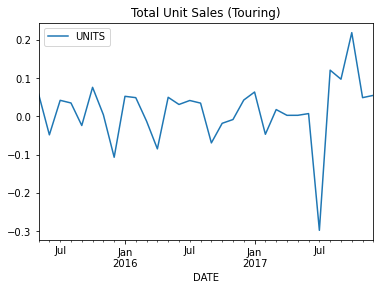

<Figure size 1080x720 with 0 Axes>

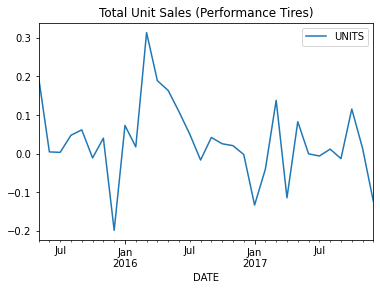

<Figure size 1080x720 with 0 Axes>

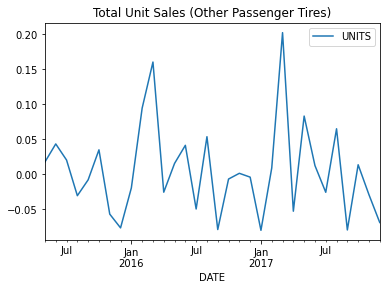

<Figure size 1080x720 with 0 Axes>

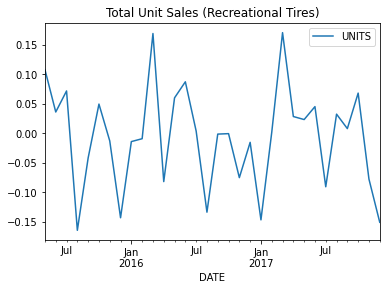

<Figure size 1080x720 with 0 Axes>

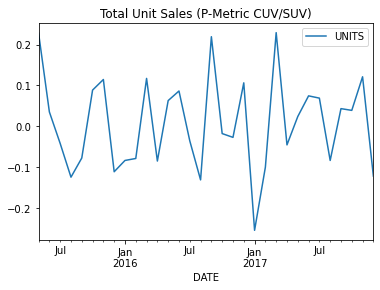

<Figure size 1080x720 with 0 Axes>

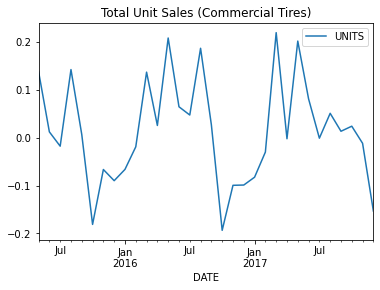

In [33]:
plot_ts_from_dict(data_dict_log)

<Figure size 1080x720 with 0 Axes>

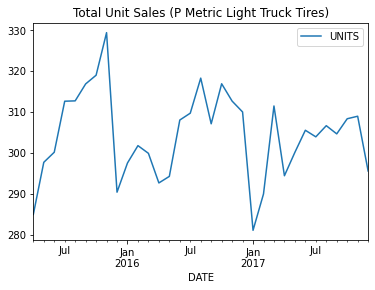

<Figure size 1080x720 with 0 Axes>

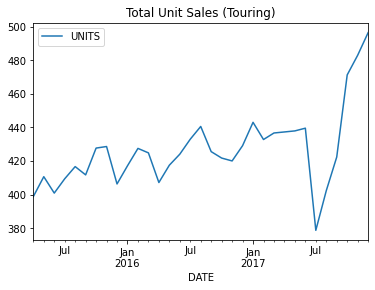

<Figure size 1080x720 with 0 Axes>

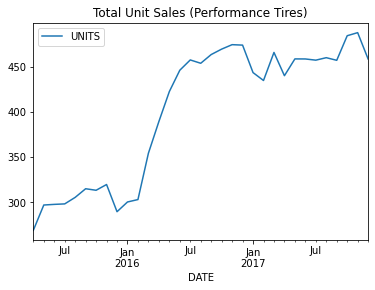

<Figure size 1080x720 with 0 Axes>

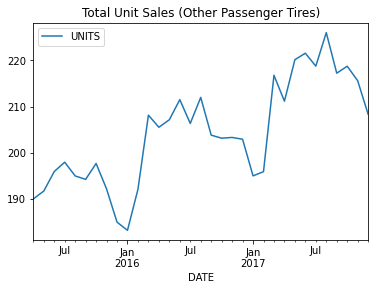

<Figure size 1080x720 with 0 Axes>

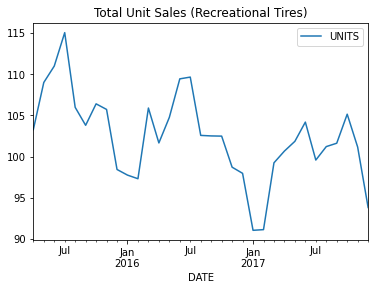

<Figure size 1080x720 with 0 Axes>

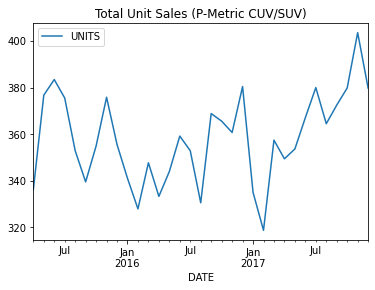

<Figure size 1080x720 with 0 Axes>

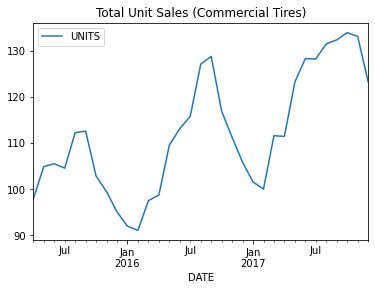

In [34]:
plot_ts_from_dict(data_dict_sqrt)

In [68]:
data_dict.keys()

dict_keys(['P Metric Light Truck Tires', 'Touring', 'Performance Tires', 'Other Passenger Tires', 'Recreational Tires', 'P-Metric CUV/SUV', 'Commercial Tires'])

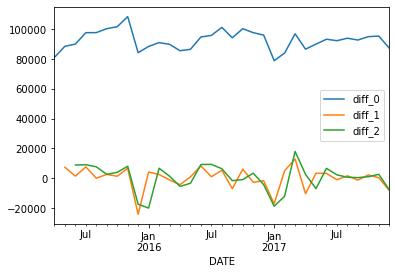

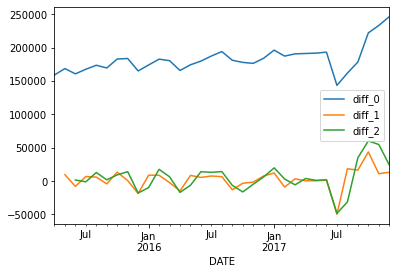

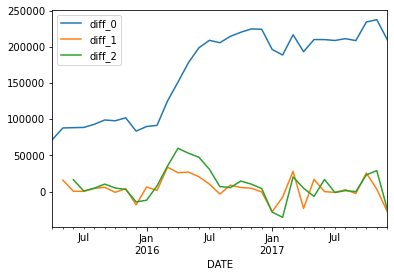

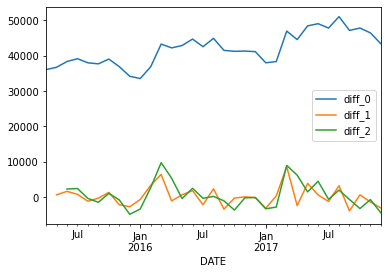

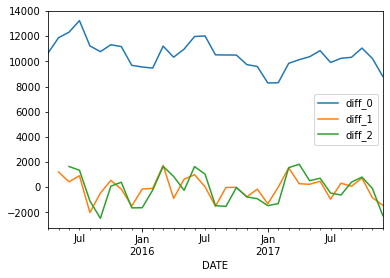

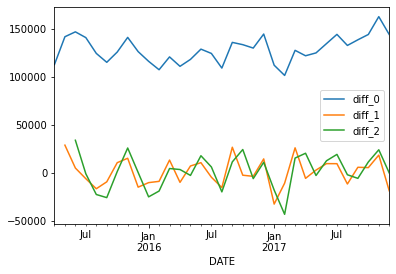

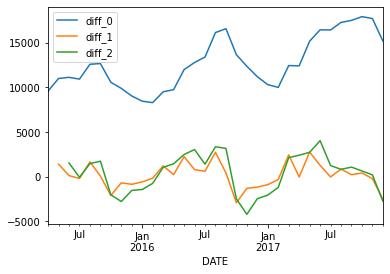

In [69]:
for k in data_dict.keys():
    feat = k
    train_period = "2017"

    a = data_dict[feat][:train_period]
    b = data_dict_diff_1[feat][:train_period]
    c = data_dict_diff_2[feat][:train_period]

    temp = pd.concat([a, b, c], axis=1)
    temp.columns = ["diff_0","diff_1","diff_2"]

    fig, ax = plt.subplots()
    temp.plot(ax=ax)
    plt.show()

### ACF and PACF Plots

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


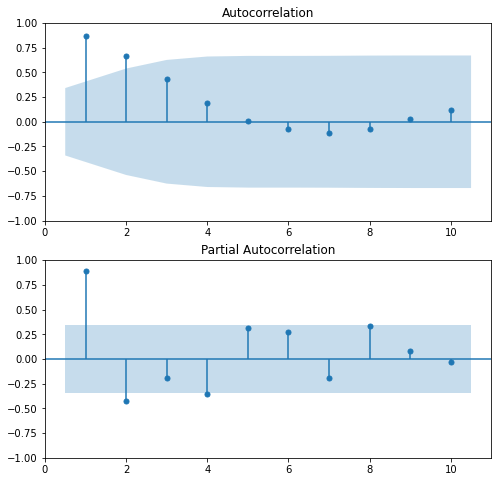

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


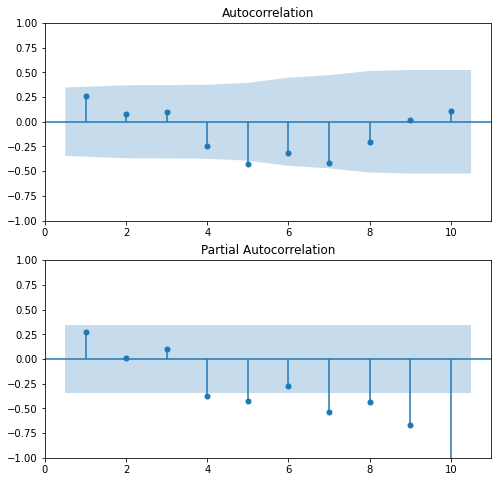

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


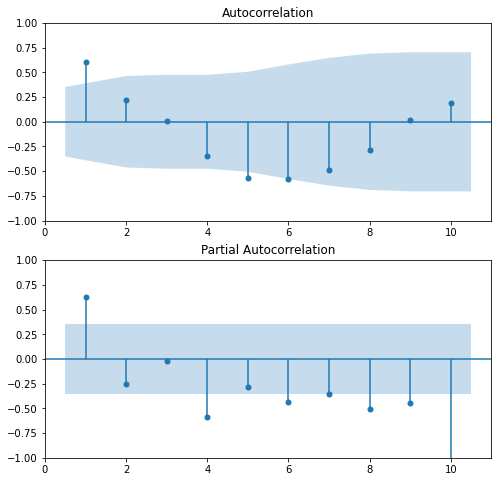

In [79]:
for i in [a, b, c]:

    # create figure
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
    
    # make ACF plot
    plot_acf(i, lags=10, zero=False, ax=ax1)
    # make PACF plot
    plot_pacf(i, lags=10, zero=False, ax=ax2)
    plt.show()

### AIC & BIC

In [92]:
#results_table = pd.DataFrame(index=data_dict.keys(),
#                               columns=["p-val", "aic", "q-val", "bic"])

order_aic_bic = []


for k in data_dict.keys():
    # loop over AR order
    for p in range(3):
        # loop over MA order
        for q in range(3):
            model = ARIMA(data_dict[k], order=(p,0,q))
            results = model.fit()
            # add order and scores to list
            order_aic_bic.append((k, p, q, results.aic, results.bic))

order_aic_bic

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarnin

[('P Metric Light Truck Tires', 0, 0, 897.4999672285907, 901.0223674599778),
 ('P Metric Light Truck Tires', 0, 1, 890.9397340371114, 896.2233343841921),
 ('P Metric Light Truck Tires', 0, 2, 891.2122551119237, 898.2570555746979),
 ('P Metric Light Truck Tires', 1, 0, 888.300091706341, 893.5836920534217),
 ('P Metric Light Truck Tires', 1, 1, 890.1234458896148, 897.168246352389),
 ('P Metric Light Truck Tires', 1, 2, 892.0331180194676, 900.8391185979353),
 ('P Metric Light Truck Tires', 2, 0, 890.1661075733051, 897.2109080360793),
 ('P Metric Light Truck Tires', 2, 1, 892.0793849636142, 900.885385542082),
 ('P Metric Light Truck Tires', 2, 2, 894.0052223292676, 904.5724230234289),
 ('Touring', 0, 0, 1143.857432829602, 1147.379833060989),
 ('Touring', 0, 1, 999.8736400382811, 1005.1572403853618),
 ('Touring', 0, 2, 990.7384399387445, 997.7832404015187),
 ('Touring', 1, 0, 953.0334720299572, 958.3170723770379),
 ('Touring', 1, 1, 955.099587676845, 962.1443881396192),
 ('Touring', 1, 2, 9

In [96]:
order_aic_bic_df = pd.DataFrame(order_aic_bic, columns=["group","p","q","aic","bic"])
order_aic_bic_df.set_index("group")

,p,q,aic,bic
group,,,,
P Metric Light Truck Tires,0,0,897.499967,901.022367
P Metric Light Truck Tires,0,1,890.939734,896.223334
P Metric Light Truck Tires,0,2,891.212255,898.257056
P Metric Light Truck Tires,1,0,888.300092,893.583692
P Metric Light Truck Tires,1,1,890.123446,897.168246
...,...,...,...,...
Commercial Tires,1,1,758.163217,765.208018
Commercial Tires,1,2,759.168492,767.974493
Commercial Tires,2,0,757.504248,764.549049
